# Kaggle's Titanic Challenge

<div style="width: 100%; overflow: hidden;">
     <div style="width: 75%; float: left;"> 
     This notebook presents feature engineering using the well known <a href='https://www.kaggle.com/c/titanic'>Titanic challenge from Kaggle</a>. This document is meant for documentation purposes demonstrating feature analysis using <a href='https://pandas.pydata.org/docs/user_guide/index.html#user-guide'>Pandas</a> and is intended for beginners. The default settings will lead to a test data classification accuracy of about 80% when submitted on Kaggle and rank among the top 3-4% on <a href='https://www.kaggle.com/c/titanic/leaderboard'>its leaderboard</a>.<br>
     <img src="https://upload.wikimedia.org/wikipedia/commons/4/45/1912_Titanic_Departure_Colorized.jpg" style="width:450px;text-align:left;vertical-align: middle;"/>
     <br>source: wikimedia.org<br>
     <br>last update: 19/12/2020
     </div>
     <div style="margin-left: 80%;">
        <b>Author</b><br><br>
        <a href='http://www.christopherhahne.de', style="text-decoration: None; text-align: left;">
            <img align="left" src="http://www.christopherhahne.de/images/about.jpg" width="78"/>
            <br><br><br><br><br><br>
            <b>Christopher<br>Hahne, PhD</b>
        </a>
    </div>
</div>

## Data acquisition

We first load the official Kaggle csv files into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

import numpy as np
import pandas as pd
import os

train_data, test_data = None, None
paths = ['.', '/kaggle/input', 'data']

for path in paths:
    if os.path.exists(os.path.join(path, "titanic", "train.csv")) and os.path.exists(os.path.join(path, "titanic", "test.csv")):
        train_data = pd.read_csv(os.path.join(path, "titanic", "train.csv"))
        test_data = pd.read_csv(os.path.join(path, "titanic", "test.csv"))
        break

if not isinstance(train_data, pd.DataFrame) or not isinstance(test_data, pd.DataFrame):
    raise FileNotFoundError("Couldn't find csv files in %s" % paths)

For better result assessment, we further load the entire data set and extract the ground truth test data.

In [2]:
import re

if os.path.exists(os.path.join(path, "titanic", "test_labelled.csv")):
    test_labelled = pd.read_csv(os.path.join(path, "titanic", "test_labelled.csv"))
elif os.path.exists(os.path.join(path, "labelled-test-data", "test_labelled.csv")):
    test_labelled = pd.read_csv(os.path.join(path, "labelled-test-data", "test_labelled.csv"))

test_gt = test_labelled['survived']

for i, name in enumerate(test_labelled['name']):
    if '"' in name:
        test_labelled['name'][i] = re.sub('"', '', name)
        
for i, name in enumerate(test_data['Name']):
    if '"' in name:
        test_data['Name'][i] = re.sub('"', '', name)

test_gt = []
for name in test_data['Name']:
    test_gt.append(int(test_labelled.loc[test_labelled['name'] == name]['survived'].values[-1]))

## Kaggle's default classification

By default Kaggle presents a neat and short solution using a RandomForestClassifier based on only 4 features with an accuracy of 77.51%, which we aim to improve.

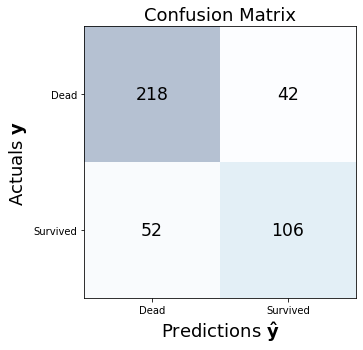

77.51 % Accuracy


In [3]:
!{sys.executable} -m pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# print confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
conf_mat = confusion_matrix(y_true=test_gt, y_pred=model.predict(X_test))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predictions $\mathbf{\hat{y}}$', fontsize=18)
plt.ylabel('Actuals $\mathbf{y}$', fontsize=18)
class_labels = ['Dead', 'Survived']
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
plt.show()

# (TP+TN)/ALL
accuracy = lambda conf_mat: (conf_mat[0, 0]+conf_mat[1, 1])/np.sum(conf_mat) * 100
print('%.2f %% Accuracy' % accuracy(conf_mat))

## Data analysis

At the beginning, it is important to familiarize oneself with the data. Let's specifically have a look at the column titles, that will act as features.

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


By reviewing the the first entries as an excerpt, we observe the following *plain features* for each passenger:

- *Survived*: 0 = No, 1 = Yes
- *Pclass*: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- *Name*: Passenger's first and second name including title
- *Sex*: Gender
- *SibSp*: Number of siblings or spouses aboard the Titanic
- *ParCh*: Number of parents or children aboard the Titanic
- *Ticket*: Ticket number
- *Fare*: Ticket fare
- *Cabin*: Cabin number
- *Embarked*: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

Let's get a first impression of the numerical distribution. From this, we observe sparse data (e.g. see Age count).

In [5]:
pd.concat([
    pd.concat([train_data, test_data]).drop(['Survived'], axis=1).isnull().sum().rename('Missing #'), 
    pd.concat([train_data, test_data]).drop(['Survived'], axis=1).isnull().sum().rename('Percent %')*100/pd.concat([train_data, test_data]).shape[0]
    ], axis=1)

,Missing #,Percent %
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,263,20.091673
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.076394
Cabin,1014,77.463713


Next, we visualize existing feature data to analyze relations and to make assumptions on potential underlying concepts.

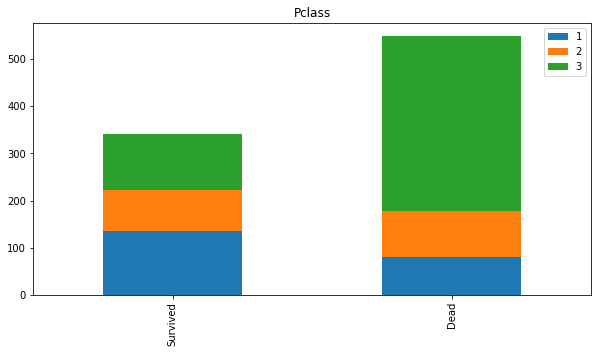

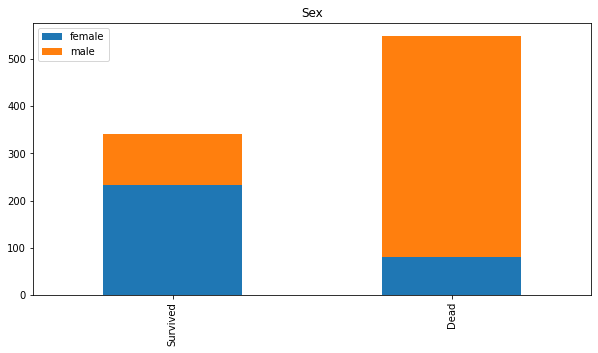

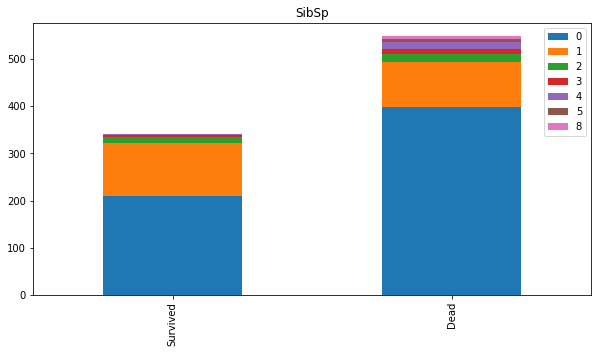

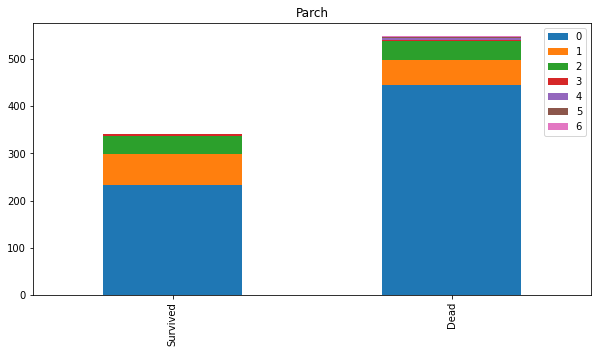

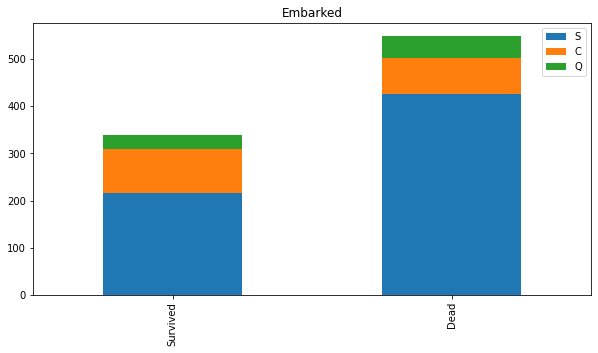

In [6]:
def bar_chart(feature, df):
    survived = df[df['Survived']==1][feature].value_counts()
    dead = df[df['Survived']==0][feature].value_counts()
    feat_df = pd.DataFrame([survived, dead])
    feat_df.index = ['Survived', 'Dead']
    feat_df.plot(kind='bar', stacked=True, figsize=(10, 5), title=feature)

bar_chart('Pclass', train_data)
bar_chart('Sex', train_data)
bar_chart('SibSp', train_data)
bar_chart('Parch', train_data)
bar_chart('Embarked', train_data)

From the plots above, we get an idea of how much of an impact class, gender and number of family members onboard (siblings/spouses, parents/children) had on the survival/death rate. To see how features depend on each other, it is meaningful to catch a glimpse on the correlation matrix.

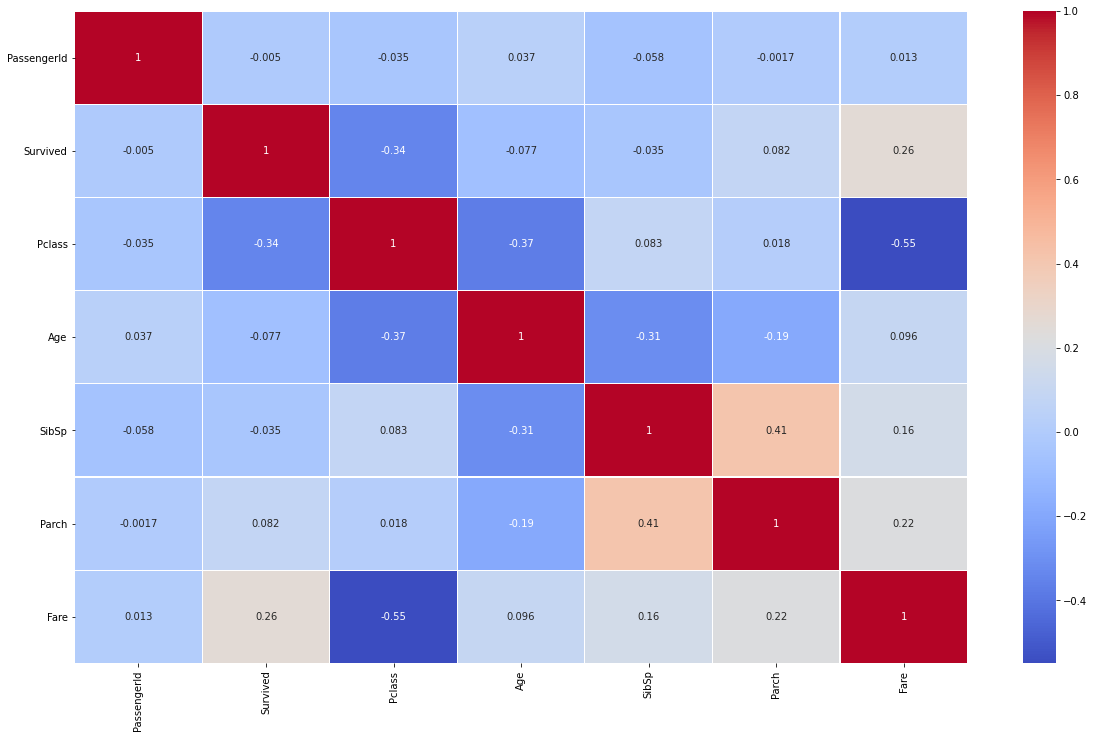

In [7]:
import seaborn as sns
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

From the correlation matrix, we observe strong correlations between *Pclass* and *Fare* as well as *SibSp* and *Parch*, which appear reasonable. These links will be useful for data imputation as demonstrated in the following feature engineering stage.

## Feature Engineering

The major task for a potential improvement on the survival prediction is to extract, transform, reduce or simplify the given passenger data. For that purpose, we make a copy of the original data frame which is subject to change.

In [8]:
import copy

# copy data for adjustments
train_df, test_df = copy.deepcopy(train_data), copy.deepcopy(test_data)

### Binary Label Conversion

First, it may be obvious to take the given gender information and convert the original string type to binary values.

In [9]:
# binary mapping
sex_mapping = {"male": 0, "female": 1}

for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].map(sex_mapping)
    df['Sex'].astype('bool')

### Feature Extraction (Title & Ethnicity from Passenger Name)

Passenger names contain rich information encoded as strings. One of the most common approaches is to extract the salutation and re-organize them into groups with specific titles.

In [10]:
for df in [train_df, test_df]:
    df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.concat([train_df, test_df])['Title'].value_counts()

Mr          745
Miss        283
Mrs         183
Master       63
Dr           10
Rev           9
Mme           2
Mlle          2
Col           2
Don           2
Major         2
Jonkheer      1
Capt          1
Ms            1
Countess      1
Sir           1
Lady          1
Name: Title, dtype: int64

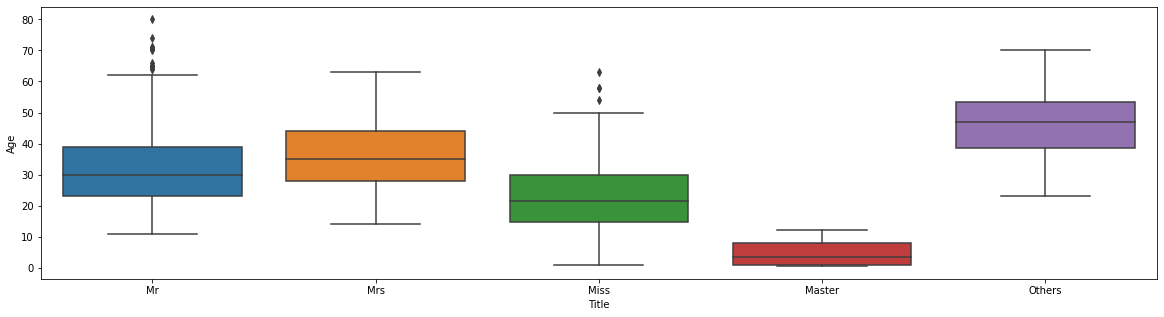

In [11]:
if False:
    # extract title-survival chance
    title_mapping_probs = {}
    title_keys = pd.concat([train_df, test_df])['Title'].value_counts().index.to_list()
    for title in title_keys:
        title_mapping_probs[title] = train_df[train_df['Title']==title].Survived.mean()
    # account for title "Dona" which occurs in test data
    title_mapping_probs['Dona'] = train_df[train_df['Title']=='Don'].Survived.mean()

    title_mapping_orig = {
                            "Mr": 0, "Miss": 1, "Mrs": 2,
                            "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                            "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona": 5, "Mme": 3, "Capt": 3, "Sir": 3
                          }

    title_map_alt = {   
                        # likely to leave last                           
                        "Mr": 1,                                                                
                        "Rev": 2,
                        # likely to leave first
                        "Miss": 3,  "Ms": 3, "Mrs": 3, "Mlle": 3,
                        "Master": 4, "Dr": 4, "Col": 4, "Major": 4,
                        # noble titles
                        "Jonkheer": 5, "Countess": 5, "Lady": 5, "Don": 5, "Dona": 5, "Mme": 5, "Sir": 5, "Capt": 5,
                    }

    # map title categories to numerical values
    for df in [train_df, test_df]:
        df['TitleGroup'] = df['Title'].map(title_map_alt)

if True:
    # group titles into 5 categories
    for df in [train_df, test_df]:
        red_title_keys = ['Mr', 'Miss', 'Mrs', 'Master']
        # combine similar titles to group of common titles
        df['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss', inplace=True)
        df['Title'].replace(['Lady'], 'Mrs', inplace=True)
        df['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
        # form a group that consists of rare titles
        df['Title'][~df['Title'].isin(red_title_keys)] = 'Others'

    # convert categories to numerical values
    for df in [train_df, test_df]:
        df['TitleGroup'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Others': 4}).astype('int')

sns.boxplot(x='Title', y='Age', data=train_df)
fig=plt.gcf()
fig.set_size_inches(20, 5)
plt.show()

A variety of nationalities were on board of the Titanic. Given that the ship was British-flagged, speaking English might have been of a great advantage when allocating seats in lifeboats. Below are attempts to generate nationality data from the passenger names.

2021-01-24 19:57:49,640 loading file /Users/Admin/PycharmProjects/18_optimizay/venv/lib/python3.7/site-packages/name2nat/best-model.pt
2021-01-24 19:57:53,408 loading file /Users/Admin/PycharmProjects/18_optimizay/venv/lib/python3.7/site-packages/name2nat/best-model.pt


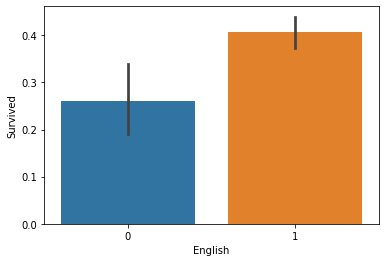

In [12]:
# language feature generation

!{sys.executable} -m pip install name2nat
try:
    from name2nat import Name2nat
    found = True
except ImportError:
    found = False

if found:
    eng_lang_keys = ['English', 'American', 'British', 'Irish', 'Australian', 'Canadian', 'German', 'French', 'Austrian', 'Dutch']

    for df in [test_df, train_df]:
        # split fore- and surname
        names = df['Name'].str.split(',', expand=True)
        # remove title from surname
        names[1] = names[1].str.extract('. ([A-Za-z]+)', expand=False)
        # concatenate fore- and surname
        names = names[1] + ' ' + names[0]
        # treat missing names
        names.fillna('Unknown', inplace=True)
        # convert to list
        name_list = names.tolist()
        # estimate nationality
        my_nanat = Name2nat()
        nation_df = pd.DataFrame(my_nanat(name_list, top_n=3))

        # English language mapping
        eng_col = []
        for row in nation_df[1]:
            eng_col.append(1 if row[0][0] in eng_lang_keys and row[0][1] >= .1 else 0)
        # append result to current data frame
        df['English'] = eng_col

    comp_df = pd.concat([df['Name'], names, df['Survived'], df['English'], nation_df[1]], axis=1)
    #comp_df.head(40)
    
    sns.barplot(x="English", y="Survived", data=train_df)
    plt.show()

As there seems to be a link between language and survival, we may regard people's ethnicity as an additional measure.

In [13]:
 # ethnicity feature generation

!{sys.executable} -m pip install ethnicolr
 try:
    from ethnicolr import census_ln
    found = True
except ImportError:
    found = False

if found:
    for df in [train_df, test_df]:
        names = df['Name'].str.split(',', expand=True)
        estimates = census_ln(names, namecol=0)
        df['Ethnicity'] = estimates['pctwhite']
        df['Ethnicity'].fillna(value=df['Ethnicity'].median(), inplace=True)
        df['Ethnicity'] = df.Ethnicity.astype(float)
        ethn_arr = df.Ethnicity.to_numpy()
        # normalization
        df['Ethnicity'] = (ethn_arr-ethn_arr.min()) / (ethn_arr.max()-ethn_arr.min())

    train_df.head()

### Imputation of missing data

From the presence of NaN values, we observe that our data ia partially incomplete. Instead of removing incomplete data columns and their useful data, we may employ **data imputation** techniques and fill missing information with reasonable guesses.

With regards to the ticket *fare*, we fill the single missing entry by a corresponding *Pclass*-grouped mean since the *fare* feature strongly correlates with passenger class.

In [14]:
# fare imputation - group-based mean
for df in [train_df, test_df]:
    group_df = df.groupby(['Pclass', 'Title'], sort=False)['Fare']
    df['Fare'] = group_df.apply(lambda x: x.fillna(x.mean()))

Missing age information is imputed similarly, whereas groups rely on more features from which we infer the median value.

In [15]:
# age imputation - conditional group-based median

# print some feature information
train_age_nan_s = round(train_df[train_df.Age.isnull()]['Survived'].sum()/train_df.Age.isnull().sum(), 3)
print('Passenger number without original age information is %s with %s survival chance for training data and %s with unknown survival rate for test data.' % (train_df.Age.isnull().sum(), train_age_nan_s, test_df.Age.isnull().sum()))

# prepare grouped medians dataframe
group_df = pd.concat([train_df, test_df]).groupby(['Sex', 'Title', 'Pclass']).median().reset_index()[['Sex', 'Title', 'Pclass', 'Age']]
group_df.head()

def fill_age(row):
    condition = (
        (group_df['Sex'] == row['Sex']) & 
        (group_df['Title'] == row['Title']) & 
        (group_df['Pclass'] == row['Pclass'])
    )
    if np.isnan(group_df[condition]['Age'].values[0]):
        condition = (
            (group_df['Sex'] == row['Sex']) & 
            (group_df['Pclass'] == row['Pclass'])
        )

    return group_df[condition]['Age'].values[0]

if True:
    for df in [train_df, test_df]:
        # fill the missing values of the Age variable based on groupd medians
        df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
elif False:
    # fill missing values with dedicated value representing the group of missing data
    for df in [train_df, test_df]:
        df[df.Age.isnull()]['Age'] = -1

Passenger number without original age information is 177 with 0.294 survival chance for training data and 86 with unknown survival rate for test data.


As an alternative to this, we may assign a dedicated class value for a group of passengers that lacks certain feature information.

In [16]:
# cabin imputation - assign 'U' unknown cabin information
for df in [train_df, test_df]:
    df['Cabin'].fillna('U', inplace=True)

In [17]:
# embarked imputation
for df in [train_df, test_df]:
    df['Embarked'].fillna('U', inplace=True)

# embarkment hierarchy
embarked_mapping = {"U": 0, "S": 1, "C": 2, "Q": 3}
for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].map(embarked_mapping)

### Binning
To reduce feature complexity, numerical values may be grouped together in several bins, which act as feature categories. Let's have a look at the distribution of the *Fare* feature and make a reasonable choice on the boundaries.

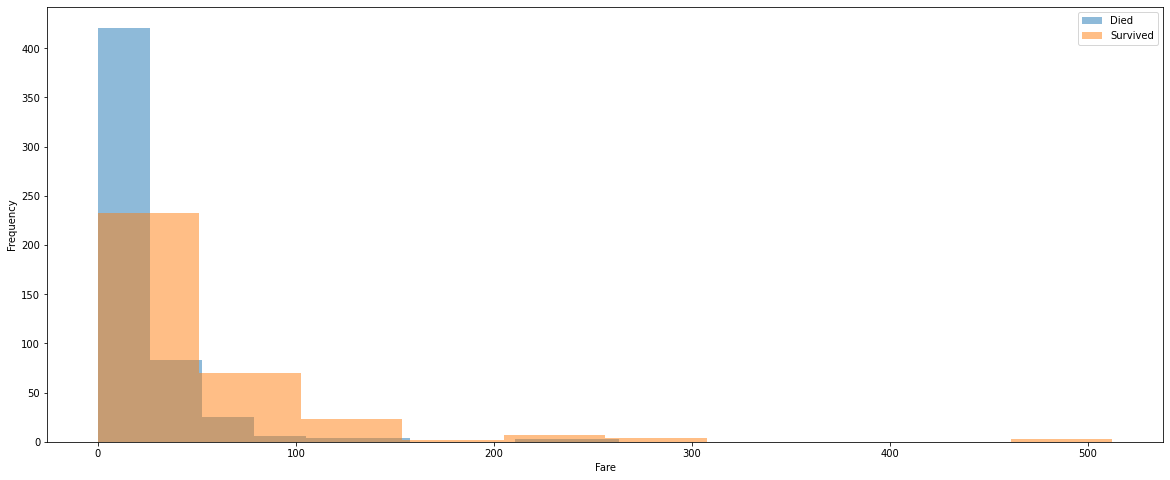

In [18]:
fig, ax = plt.figure(figsize=(20, 8)), plt.axes()
ax = train_df[train_df['Survived']==0]['Fare'].plot.hist(alpha=0.5, label='Died')
ax = train_df[train_df['Survived']==1]['Fare'].plot.hist(alpha=0.5, label='Survived')
ax.set_xlabel('Fare')
ax.legend()

In [19]:
# fare binning
if True:
    # manual fare binning
    for df in [train_df, test_df]:
        df.loc[ df['Fare'] <= 17, 'Fare'] = 0
        df.loc[(df['Fare'] > 17) & (df['Fare'] <= 30), 'Fare'] = 1
        df.loc[(df['Fare'] > 30) & (df['Fare'] <= 100), 'Fare'] = 2
        df.loc[ df['Fare'] > 100, 'Fare'] = 3
        df['Fare'] = df['Fare'].astype('int')
elif False:
    # automatic fare binning using sklearn
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    for df in [train_df, test_df]:
        df['Fare'] = pd.qcut(df['Fare'], 5)
        df['Fare'] = label.fit_transform(df['Fare'])

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup,English,Ethnicity
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,0,U,1,Mr,0,1,0.979182
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,2,C85,2,Mrs,2,1,0.917592
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,0,U,1,Miss,1,1,0.986301
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,2,C123,1,Mrs,2,1,0.937655
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,0,U,1,Mr,0,1,0.686442


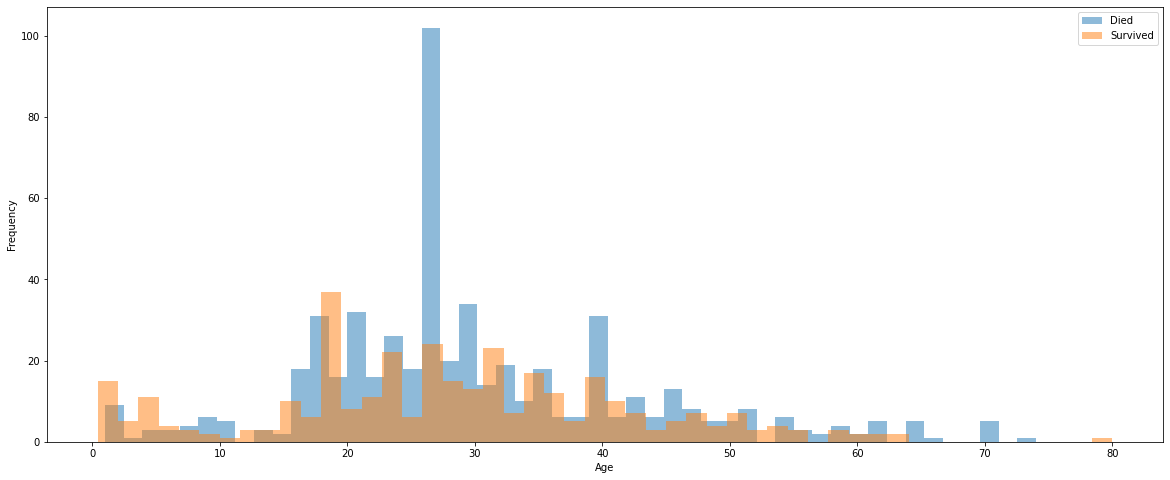

In [20]:
age_survi = np.array(train_df[train_df['Survived']==1]['Age'])
age_death = np.array(train_df[train_df['Survived']==0]['Age'])

fig, ax = plt.figure(figsize=(20, 8)), plt.axes()
ax = train_df[train_df['Survived']==0]['Age'].plot.hist(bins=50, alpha=0.5, label='Died')
ax = train_df[train_df['Survived']==1]['Age'].plot.hist(bins=50, alpha=0.5, label='Survived')
ax.set_xlabel('Age')
ax.legend()

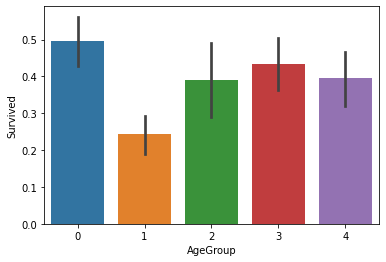

In [21]:
# age binning
if False:
    # manual age group numeric labels
    for df in [train_df, test_df]:
        df.loc[ df['Age'] <= 5, 'Age'] = 0
        df.loc[(df['Age'] > 5) & (df['Age'] <= 15), 'Age'] = 1
        df.loc[(df['Age'] > 15) & (df['Age'] <= 25), 'Age'] = 2
        df.loc[(df['Age'] > 25) & (df['Age'] <= 35), 'Age'] = 3
        df.loc[(df['Age'] > 35) & (df['Age'] <= 50), 'Age'] = 4
        df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'Age'] = 5
        df.loc[ df['Age'] > 60, 'Age'] = 6
        df['Age'] = df['Age'].astype('int')
elif False:
    # manual age group string labels
    for df in [train_df, test_df]:
        bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
        labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
        df['AgeGroup'] = pd.cut(df["Age"], bins, labels = labels)

        age_mapping = {'Baby': 6, 'Child': 2, 'Teenager': 5, 'Student': 1, 'Young Adult': 4, 'Adult': 3, 'Senior': 0, 'Unknown': 1}
        df['AgeGroup'] = df['AgeGroup'].map(age_mapping)
        df["AgeGroup"].fillna(1, inplace=True)

elif True:
    # automatic binning using sklearn
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    for df in [train_df, test_df]:
        df['AgeGroup'] = pd.qcut(df['Age'], 5)
        df['AgeGroup'] = label.fit_transform(df['AgeGroup'])

    # bar plot of age vs. survival
    sns.barplot(x="AgeGroup", y="Survived", data=train_df)
    plt.show()

## Cabin

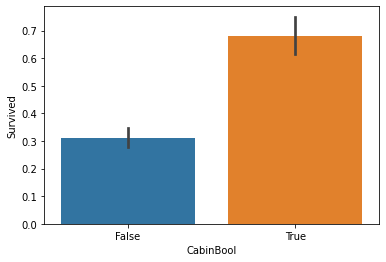

Percentage of CabinBool = 1 who survived: 68.18181818181817
Percentage of CabinBool = 0 who survived: 31.04895104895105


In [22]:
if True:
    for df in [train_df, test_df]:
        df["CabinBool"] = df["Cabin"].str.isalnum() & np.logical_not(df["Cabin"].str.isalpha())

    sns.barplot(x="CabinBool", y="Survived", data=train_df)
    plt.show()

    print("Percentage of CabinBool = 1 who survived:", train_df["Survived"][train_df["CabinBool"] == 1].value_counts(normalize = True)[1]*100)
    print("Percentage of CabinBool = 0 who survived:", train_df["Survived"][train_df["CabinBool"] == 0].value_counts(normalize = True)[1]*100)

if False:
    Pclass1 = train_df[train_df['Pclass']==1]['Cabin'].value_counts()
    Pclass2 = train_df[train_df['Pclass']==2]['Cabin'].value_counts()
    Pclass3 = train_df[train_df['Pclass']==3]['Cabin'].value_counts()
    cabin_df = pd.DataFrame([Pclass1, Pclass2, Pclass3]) 
    cabin_df.index = ['1st class', '2nd class', '3rd class']

    for cabin_letter in train_df['Cabin'].value_counts().keys():
        print(str(cabin_letter), train_df[train_df['Cabin']==cabin_letter].Survived.mean())

In [23]:
if True:
    # reduce cabin data to first letter
    for df in [train_df, test_df]:
        df['Cabin'] = df['Cabin'].str[:1]

    # map cabin data to numerical values
    cabin_mapping = {"U": 0.0, "A": 0.4, "B": 0.8, "C": 1.2, "D": 1.6, "E": 2.0, "F": 2.4, "G": 2.8, "T": 3.2}
    for df in [train_df, test_df]:
        df['Cabin'] = df['Cabin'].map(cabin_mapping)

    train_df.head()

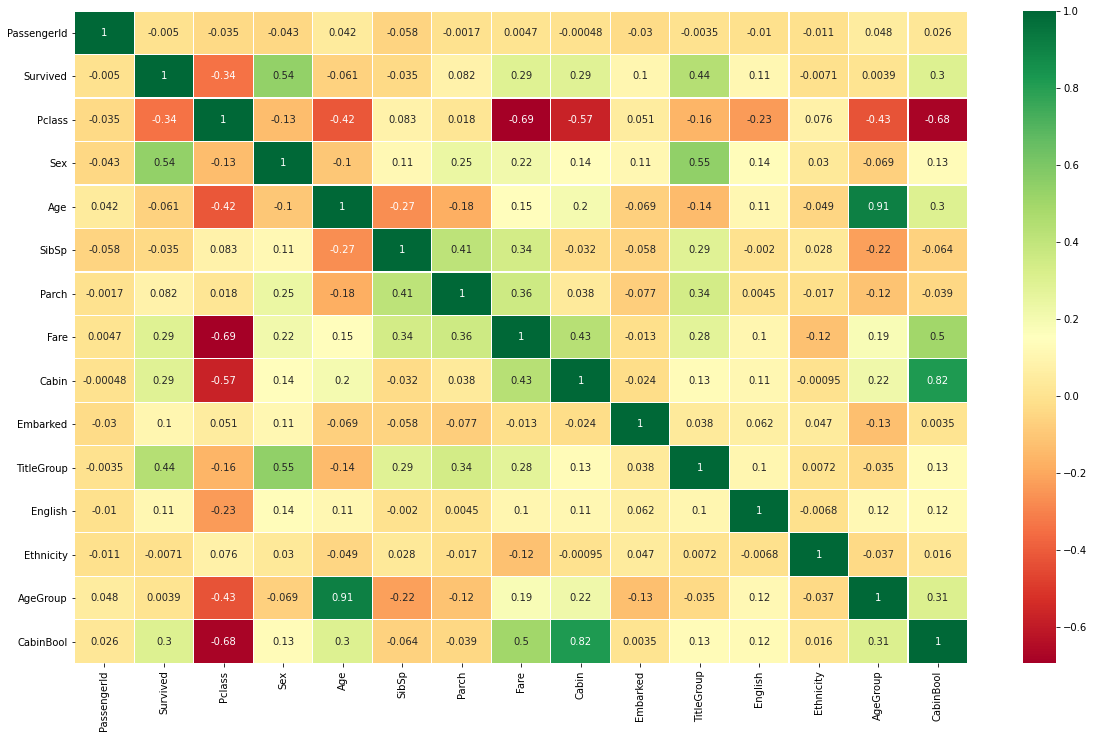

In [24]:
import seaborn as sns
sns.heatmap(train_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

### One-Hot Encoding

Another technique often used for feature engineering is called One-Hot Encoding (OHE), which is meant for categorical features. OHE involves the transformation of single feature into several binary labels and thus yields a higher dimensionality. OHE helps avoiding numerical values, which is recommended in cases where the order of labels is irrelevant. Otherwise, the numerical order may influence the decision making even when there is no hierarchical relationship.

In [25]:
features_to_be_encoded = ['Embarked']

for feature in features_to_be_encoded:
    for df in [train_df, test_df]:

        # perform One-Hot-Encoding (OHE) with columns in new dataframe
        ohe_df = pd.get_dummies(df[feature], prefix=feature, drop_first=False)

        # drop original column
        df.drop([feature], axis=1, inplace=True)
        
        # join the new colum ns with original dataframe
        for col in ohe_df.columns.values:
            df[col] = ohe_df[col]

    # add columns in test data which are not present
    missing_cols = [term for term in train_df.columns.values if term.startswith(feature) and term not in test_df.columns]
    for col in missing_cols:
        test_df[col] = 0

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,TitleGroup,English,Ethnicity,AgeGroup,CabinBool,Embarked_0,Embarked_1,Embarked_2,Embarked_3
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,0,...,Mr,0,1,0.979182,1,False,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,2,...,Mrs,2,1,0.917592,3,True,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,0,...,Miss,1,1,0.986301,1,False,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,2,...,Mrs,2,1,0.937655,3,True,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,0,...,Mr,0,1,0.686442,3,False,0,1,0,0


### Feature reduction

Due to feature similarity between *SibSp* and *Parch* feature as seen in above correlation plot, we combine these two data columns to a single one and thus reduce the number of features.

In [26]:
# family size feature
for df in [train_df, test_df]:
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,TitleGroup,English,Ethnicity,AgeGroup,CabinBool,Embarked_0,Embarked_1,Embarked_2,Embarked_3,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,0,...,0,1,0.979182,1,False,0,1,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,2,...,2,1,0.917592,3,True,0,0,1,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,0,...,1,1,0.986301,1,False,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,2,...,2,1,0.937655,3,True,0,1,0,0,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,0,...,0,1,0.686442,3,False,0,1,0,0,1


To further simplify the family size information, we convert the number of relatives per passenger to a binary level stating whether a person is travelling alone or accompanied by others.

In [27]:
family_mapping_bin = {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1}

# single passenger mapping
for df in [train_df, test_df]:
    df['FamilyBool'] = df['FamilySize'].map(family_mapping_bin)

### Family-connected survival from Ticket
According to a blog post from [Vidhya](https://medium.com/analytics-vidhya/kaggle-titanic-survival-prediction-top-3-ea6c8dcc9b6c), it is a viable approach to gather information about relatives from the ticket data. The goal behind this assumption is that family members are likely to survive or die together as a collective.

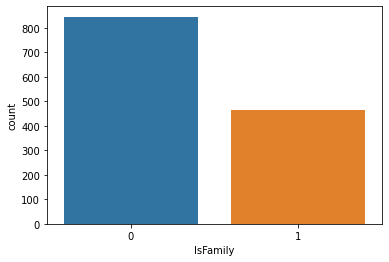

In [28]:
comb_df = pd.concat([train_df, test_df])
comb_df['Surname'] = comb_df['Name'].str.extract(r'([A-Za-z]+),', expand=False)
comb_df['TixPref'] = comb_df['Ticket'].str.extract(r'(.*\d)', expand=False)
comb_df['SurTix'] = comb_df['Surname'] + comb_df['TixPref']
comb_df['IsFamily'] = comb_df['SurTix'].duplicated(keep=False)*1

sns.countplot(comb_df['IsFamily'])
plt.show()

In [29]:
comb_df['Child'] = comb_df['Age'].map(lambda x: 1 if x <=16 else 0)
fam_with_child = comb_df[(comb_df['IsFamily']==1) & (comb_df['Child']==1)]['SurTix'].unique()

comb_df['FamilyId'] = 0

for i, tix in enumerate(fam_with_child):
    comb_df.loc[comb_df['SurTix']==tix, ['FamilyId']] = i+1

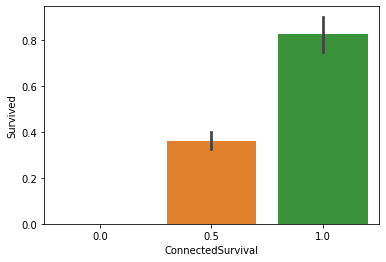

In [30]:
comb_df['ConnectedSurvival'] = 0.5 
survived_fam = comb_df.groupby('FamilyId')['Survived'].sum()

for i in range(1, len(fam_with_child)+1):
    if survived_fam[i] >= 1:
        comb_df.loc[comb_df['FamilyId']==i, ['ConnectedSurvival']] = 1
    elif survived_fam[i] == 0:
        comb_df.loc[comb_df['FamilyId']==i, ['ConnectedSurvival']] = 0

train_df = comb_df[:len(train_df)]
test_df = comb_df[len(train_df):]

sns.barplot(x='ConnectedSurvival', y='Survived', data=train_df)
plt.show()

### Feature selection

Finally, we can reflect on how much the engineered features contribute to a model. Instead of a heuristic trial and error, we analyze the importance of each feature prior to manual selection.

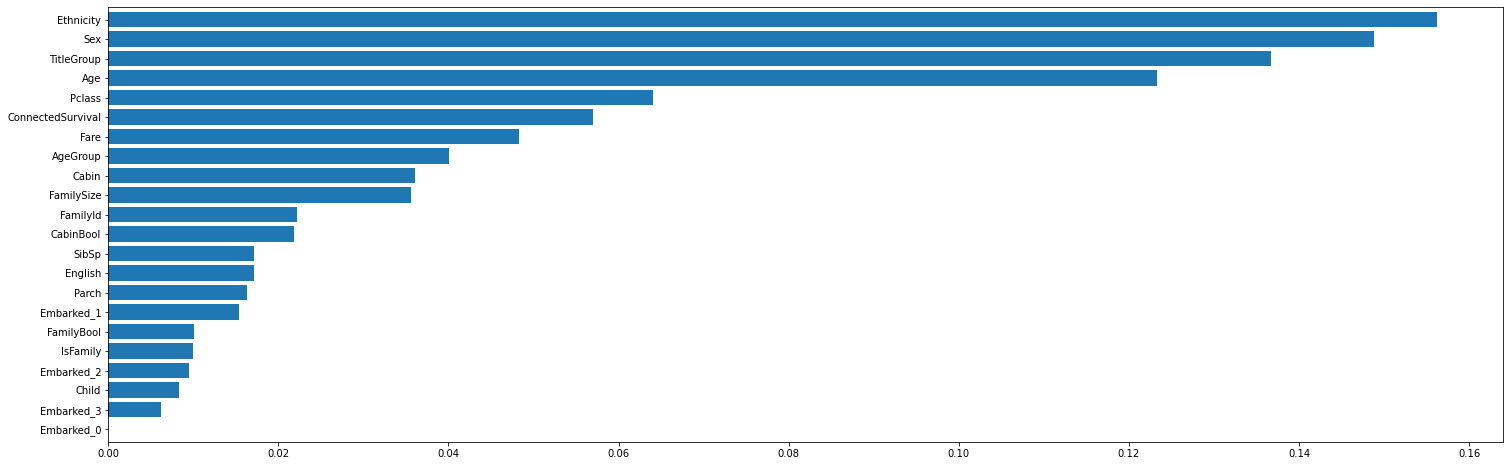

In [31]:
# only select columns present in training data
X = train_df.drop(['Name', 'Ticket', 'TixPref', 'SurTix', 'Surname', 'Title', 'Survived', 'PassengerId'], axis=1).to_numpy()
X_test = test_df.drop(['Name', 'Ticket', 'TixPref', 'SurTix', 'Surname', 'Title', 'Survived', 'PassengerId'], axis=1).to_numpy()
features_preselect = train_df.drop(['Name', 'Ticket', 'TixPref', 'SurTix', 'Surname', 'Title', 'Survived', 'PassengerId'], axis=1).columns.values

if True:
    from sklearn.feature_selection import SelectFromModel

    rf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
    X_all = train_df[features_preselect].to_numpy()
    rf.fit(X_all, y)

    features = pd.DataFrame()
    features['feature'] = features_preselect
    try:    
        feat_importance = pd.Series(rf.feature_importances_, features_preselect)
        feat_importance.sort_values(ascending=True, inplace=True)
        features.set_index('feature', inplace=True)
        feat_importance.plot(kind='barh', width=0.8, figsize=(25, 8))
    except AttributeError as e:
        print(e)

if False:
    model = SelectFromModel(rf, prefit=True)
    X = model.transform(X_all)
    print('Reduced number of features from %s down to %s.' % (X_all.shape[1], X.shape[1]))

    X_test_all = test_df[features_preselect].to_numpy()
    X_test = model.transform(X_test_all)

In [32]:
features_preselect = ['Pclass', 'Sex', 'FamilyBool', 'Fare', 'ConnectedSurvival']
X = train_df[features_preselect].to_numpy()
X_test = test_df[features_preselect].to_numpy()

## Model selection and cross-validation

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV(Cs=20, solver='sag', tol=0.001, max_iter=100, verbose=0, refit=True, random_state=0)
rf = RandomForestClassifier(n_estimators=50, max_depth=4, criterion='entropy', random_state=1)
rf_opts = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

models = [logreg, logreg_cv, rf, rf_opts, gboost]

best_score, best_model = 0, models[0]
for model in models:
    print('Cross-validation of : {0}'.format(model.__str__()))
    score = np.mean(cross_val_score(model, X=X, y=y, cv=5, scoring='accuracy'))

    model.fit(X, y)
    test_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_true=test_gt, y_pred=test_pred)
    score = accuracy(conf_mat)

    print('CV score = %s \n' % round(score, 4))
    best_model = model if score > best_score else best_model
    best_score = score if score > best_score else best_score

print('The winner is %s' % best_model.__str__())
y_pred = best_model.predict(X)
test_pred = best_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_pred})
try:
    output.to_csv(os.path.join(path, 'titanic', 'my_submission.csv'), index=False)
    print("Submission file saved!")
except OSError:
    pass

Cross-validation of : LogisticRegression()
CV score = 78.9474 

Cross-validation of : LogisticRegressionCV(Cs=20, random_state=0, solver='sag', tol=0.001)
CV score = 79.6651 

Cross-validation of : RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=50,
                       random_state=1)
CV score = 80.622 

Cross-validation of : RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=5, n_estimators=6)
CV score = 81.3397 

Cross-validation of : GradientBoostingClassifier()
CV score = 80.622 

The winner is RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_leaf=5, n_estimators=6)
Submission file saved!


### Hyper-parameter tuning

The estimation models above strongly rely on hyper-parameters, which we aim to optimize iteratively using the [model_selection module from sklearn](https://scikit-learn.org/stable/modules/grid_search.html).

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

if False:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [10, 50, 100, 200, 300],
                 'criterion': ['gini', 'entropy'],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 5, 10],
                 'bootstrap': [True, False],
    }
                  
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1,
                               n_jobs=-1
                              )

    grid_search.fit(X, y)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
elif False: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X, y)
else:
    model = best_model

test_pred = model.predict(X_test).astype(int)

## Kaggle accuracy benchmark

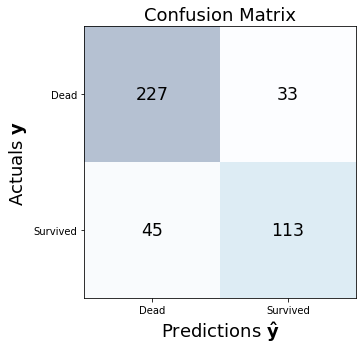

81.34 % Accuracy


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# print confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
conf_mat = confusion_matrix(y_true=test_gt, y_pred=test_pred)
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predictions $\mathbf{\hat{y}}$', fontsize=18)
plt.ylabel('Actuals $\mathbf{y}$', fontsize=18)
class_labels = ['Dead', 'Survived']
plt.xticks([0, 1], class_labels)
plt.yticks([0, 1], class_labels)
plt.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
plt.show()

# (TP+TN)/ALL
accuracy = lambda conf_mat: (conf_mat[0, 0]+conf_mat[1, 1])/np.sum(conf_mat) * 100
print('%.2f %% Accuracy' % accuracy(conf_mat))